# Cryptocurrency Analysis with Python - MACD

In [32]:
!pip install stockstats

## **Introduction** 

Cryptocurrencies are becoming mainstream so I've decided to spend the weekend learning about it. 
we have scraped together the 
[code]({{site.url}}/assets/notebooks/2017-12-10-cryptocurrency-analysis-with-python-part1.ipynb)
to download daily Bitcoin prices and apply a simple trading strategy to it. 

Note that there already exists tools for performing this kind of analysis, eg. 
[tradeview](https://www.tradingview.com/), but this way enables more in-depth analysis.


## Requirements

- Python 3

- [Jupyter Notebook](http://jupyter.org/)

- [Pandas Data Analysis Library](https://pandas.pydata.org/) 

- [Bokeh interactive visualization library](https://bokeh.pydata.org/en/latest/)

- [stock Statistics/Indicators Calculation Helper](https://github.com/jealous/stockstats)

## Getting cryptocurrency data

We download daily Bitcoin data in USD on Bitstamp exchange. [Other exchanges](https://www.cryptocompare.com/api/#introduction) are also supported.  

In [33]:
from_symbol = 'BTC'
to_symbol = 'USD'
exchange = 'Bitstamp'
datetime_interval = 'day'

The [cryptocompare api](https://www.cryptocompare.com/api/#introduction) returns following columns:
 - **open**, the price at which the period opened,
 - **high**, the highest price reached during the period,
 - **low**, the lowest price reached during the period,
 - **close**, the price at which the period closed,
 - **volumefrom**, the volume in the base currency that things are traded into,
 - **volumeto**, the volume in the currency that is being traded.
 
We download the data and store it to a file.

In [34]:
import requests
from datetime import datetime
import pandas as pd



def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)


def download_data(from_symbol, to_symbol, exchange, datetime_interval):
    supported_intervals = {'minute', 'hour', 'day'}
    assert datetime_interval in supported_intervals,           'datetime_interval should be one of %s' % supported_intervals

    print('Downloading %s trading data for %s %s from %s' %
          (datetime_interval, from_symbol, to_symbol, exchange))
    base_url = 'https://min-api.cryptocompare.com/data/histo'
    url = '%s%s' % (base_url, datetime_interval)

    params = {'fsym': from_symbol, 'tsym': to_symbol,
              'limit': 2000, 'aggregate': 1,
              'e': exchange}
    request = requests.get(url, params=params)
    data = request.json()
    return data


def convert_to_dataframe(data):
    df = pd.io.json.json_normalize(data, ['Data'])
    df['datetime'] = pd.to_datetime(df.time, unit='s')
    df = df[['datetime', 'low', 'high', 'open',
             'close', 'volumefrom', 'volumeto']]
    return df


def filter_empty_datapoints(df):
    indices = df[df.sum(axis=1) == 0].index
    print('Filtering %d empty datapoints' % indices.shape[0])
    df = df.drop(indices)
    return df


data = download_data(from_symbol, to_symbol, exchange, datetime_interval)
df = convert_to_dataframe(data)
df = filter_empty_datapoints(df)

current_datetime = datetime.now().date().isoformat()
filename = get_filename(from_symbol, to_symbol, exchange, datetime_interval, current_datetime)
print('Saving data to %s' % filename)
df.to_csv(filename, index=False)

Filtering 0 empty datapoints
Saving data to BTC_USD_Bitstamp_day_2022-05-22.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


## Read the data

We read the data from a file so we don't need to download it again.

In [35]:

def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

df = read_dataset(filename)

Reading data from BTC_USD_Bitstamp_day_2022-05-22.csv
(2001, 6)


##  Trading strategy

A trading strategy is a set of objective rules defining the conditions that must be met for a trade entry and exit to occur. 

We are going to apply Moving Average Convergence Divergence (MACD) trading strategy, which is a popular indicator used in technical analysis. 
MACD calculates two moving averages of varying lengths to identify trend direction and duration.
Then, it takes the difference in values between those two moving averages (MACD line) 
and an exponential moving average (signal line) of those moving averages.
Tradeview has a great blog post about [MACD](https://www.tradingview.com/wiki/MACD_).

As we can see in the example below:
- exit trade (sell) when MACD line crosses below the MACD signal line,
- enter trade (buy) when MACD line crosses above the MACD signal line. 

![]( http://www.onlinetradingconcepts.com/images/technicalanalysis/MACDbuysellaltNQ.gif "MACD")

## Calculate the trading strategy
We use [stockstats](https://github.com/jealous/stockstats) package to calculate MACD.

In [36]:
from stockstats import StockDataFrame
df = StockDataFrame.retype(df)
df['macd'] = df.get('macd') # calculate MACD

stockstats adds 5 columns to dataset:
- **close_12_ema** is fast 12 days exponential moving average,
- **close_26_ema** is slow 26 days exponential moving average,
- **macd** is MACD line,
- **macds** is signal line,
- **macdh** is MACD histogram.

In [37]:
df.head()

,low,high,open,close,volumefrom,volumeto,macd,macds,macdh
datetime,,,,,,,,,
2016-11-29,721.00,733.29,730.99,730.99,5193.25,3788691.62,0.000000,0.000000,0.000000
2016-11-30,727.00,744.49,730.72,742.06,6208.19,4577304.37,0.248365,0.137981,0.110385
2016-12-01,740.18,754.98,742.06,751.60,6097.42,4569793.09,0.612302,0.332375,0.279927
2016-12-02,750.77,778.07,751.55,769.99,8062.00,6181050.26,1.426785,0.703110,0.723675
2016-12-03,752.41,770.99,770.91,762.79,2763.36,2107293.54,1.552821,0.955880,0.596941


## Visualizing trading strategy 

We use bokeh interactive charts to plot the data.

The line graph shows daily closing prices with candlesticks (zoom in).
A candlestick displays the high, low, opening  and closing prices 
for a specific period. Tradeview has a great blogpost about 
[candlestick graph](https://www.investopedia.com/terms/c/candlestick.asp).

Below the line graph we plot the MACD strategy with MACD line (blue), signal line (orange) and histogram (purple).

In [38]:
from math import pi

from bokeh.plotting import figure, show, output_notebook, output_file
output_notebook()

datetime_from = '2016-01-01 00:00'
datetime_to = '2017-12-10 00:00'


def get_candlestick_width(datetime_interval):
    if datetime_interval == 'minute':
        return 30 * 60 * 1000  # half minute in ms
    elif datetime_interval == 'hour':
        return 0.5 * 60 * 60 * 1000  # half hour in ms
    elif datetime_interval == 'day':
        return 12 * 60 * 60 * 1000  # half day in ms


df_limit = df[datetime_from: datetime_to].copy()
inc = df_limit.close > df_limit.open
dec = df_limit.open > df_limit.close

title = '%s datapoints from %s to %s for %s and %s from %s with MACD strategy' % (
    datetime_interval, datetime_from, datetime_to, from_symbol, to_symbol, exchange)
p = figure(x_axis_type="datetime",  plot_width=1000, title=title)

p.line(df_limit.index, df_limit.close, color='black')

# plot macd strategy
p.line(df_limit.index, 0, color='black')
p.line(df_limit.index, df_limit.macd, color='blue')
p.line(df_limit.index, df_limit.macds, color='orange')
p.vbar(x=df_limit.index, bottom=[
       0 for _ in df_limit.index], top=df_limit.macdh, width=4, color="purple")

# plot candlesticks
candlestick_width = get_candlestick_width(datetime_interval)
p.segment(df_limit.index, df_limit.high,
          df_limit.index, df_limit.low, color="black")
p.vbar(df_limit.index[inc], candlestick_width, df_limit.open[inc],
       df_limit.close[inc], fill_color="#D5E1DD", line_color="black")
p.vbar(df_limit.index[dec], candlestick_width, df_limit.open[dec],
       df_limit.close[dec], fill_color="#F2583E", line_color="black")

output_file("visualizing_trading_strategy.html", title="visualizing trading strategy")
show(p)

# Cryptocurrency Analysis with Python - Buy and Hold

In this part, I am going to analyze which coin (Bitcoin, Ethereum or Litecoin) was the most profitable in last two months if we would invest using buy and hold strategy. 
We'll go through the analysis of these 3 cryptocurrencies and try to give an objective answer.
You can run this code by downloading [Jupyter notebook]({{site.url}}/assets/notebooks/2017-12-25-cryptocurrency-analysis-with-python-part2.ipynb).
    
Follow me on [twitter](https://twitter.com/romanorac) to get latest updates.

![]({{site.url}}/assets/images/bitcoin-ethereum-litecoin.png "Bitcoin, Ethereum, and Litecoin")

## Requirements

- [seaborn: statistical data visualization](https://seaborn.pydata.org/)

For other requirements, see
[previous blog post](https://romanorac.github.io/cryptocurrency/analysis/2017/12/17/cryptocurrency-analysis-with-python-part1.html)
in this series.

## Getting the data

To get the latest data, see [previous blog post]({{site.url}}/cryptocurrency/analysis/2017/12/17/cryptocurrency-analysis-with-python-part1.html),
where I described how to download it using Cryptocompare API.
You can also use the [data]({{site.url}}/assets/data/) I worked with in this example.

First, we download hourly data for BTC, ETH and LTC from Coinbase exchange.
This time we work with hourly time interval as it has higher granularity.
Cryptocompare API limits response to 2000 samples, which is 2.7 months of data for each coin.

In [39]:
import pandas as pd

def get_filename(from_symbol, to_symbol, exchange, datetime_interval, download_date):
    return '%s_%s_%s_%s_%s.csv' % (from_symbol, to_symbol, exchange, datetime_interval, download_date)

def read_dataset(filename):
    print('Reading data from %s' % filename)
    df = pd.read_csv(filename)
    df.datetime = pd.to_datetime(df.datetime) # change type from object to datetime
    df = df.set_index('datetime') 
    df = df.sort_index() # sort by datetime
    print(df.shape)
    return df

## Load the data

In [40]:
df_btc = read_dataset(get_filename('BTC', 'USD', 'Coinbase', 'hour', '2017-12-24'))
df_eth = read_dataset(get_filename('ETH', 'USD', 'Coinbase', 'hour', '2017-12-24'))
df_ltc = read_dataset(get_filename('LTC', 'USD', 'Coinbase', 'hour', '2017-12-24'))

Reading data from BTC_USD_Coinbase_hour_2017-12-24.csv
(2001, 6)
Reading data from ETH_USD_Coinbase_hour_2017-12-24.csv
(2001, 6)
Reading data from LTC_USD_Coinbase_hour_2017-12-24.csv
(2001, 6)


In [41]:
df_btc.head()

,low,high,open,close,volumefrom,volumeto
datetime,,,,,,
2017-10-02 08:00:00,4435.00,4448.98,4435.01,4448.85,85.51,379813.67
2017-10-02 09:00:00,4448.84,4470.00,4448.85,4464.49,165.17,736269.53
2017-10-02 10:00:00,4450.27,4469.00,4464.49,4461.63,194.95,870013.62
2017-10-02 11:00:00,4399.00,4461.63,4461.63,4399.51,326.71,1445572.02
2017-10-02 12:00:00,4378.22,4417.91,4399.51,4383.00,549.29,2412712.73


## Extract closing prices

We are going to analyze closing prices, which are prices at which the hourly period closed. 
We merge BTC, ETH and LTC closing prices to a Dataframe to make analysis easier.

In [42]:
df = pd.DataFrame({'BTC': df_btc.close,
                   'ETH': df_eth.close,
                   'LTC': df_ltc.close})

In [43]:
df.head()

,BTC,ETH,LTC
datetime,,,
2017-10-02 08:00:00,4448.85,301.37,54.72
2017-10-02 09:00:00,4464.49,301.84,54.79
2017-10-02 10:00:00,4461.63,301.95,54.63
2017-10-02 11:00:00,4399.51,300.02,54.01
2017-10-02 12:00:00,4383.00,297.51,53.71


## Analysis

### Basic statistics

In 2.7 months, all three cryptocurrencies fluctuated a lot as you can observe in the table below. 

For each coin, we count the number of events and calculate mean, standard deviation, minimum, quartiles and maximum closing price. Quartiles divide the data into four equal groups, each group comprising a quarter of the data.

**Few interesting facts**
- The difference between the highest and the lowest BTC price was more than \$15000 in 2.7 months.
- The LTC surged from \$48.61 to \$378.66 at a certain point, which is an increase of 678.98%.

In [44]:
df.describe()

,BTC,ETH,LTC
count,2001.000000,2001.000000,2001.000000
mean,9060.256122,407.263793,106.790100
std,4404.269591,149.480416,89.142241
min,4150.020000,277.810000,48.610000
25%,5751.020000,301.510000,55.580000
50%,7319.950000,330.800000,63.550000
75%,11305.000000,464.390000,100.050000
max,19847.110000,858.900000,378.660000


### Lets dive deeper into LTC

We visualize the data in the table above with a box plot. 
A box plot shows the quartiles of the dataset with points that are determined to be outliers using a method of the [inter-quartile range](https://en.wikipedia.org/wiki/Interquartile_range) (IQR). 
`IQR = Q3 − Q1`. 
In other words, the IQR is the first quartile (25%) subtracted from the third quartile (75%).

On the box plot below, 
we see that LTC closing hourly price was most of the time between \$50 and \$100 in the last 2.7 months. 
All values over \$150 are outliers (using IQR) in our sample.

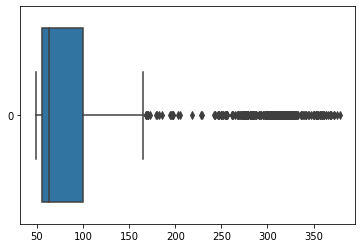

In [45]:
import seaborn as sns

ax = sns.boxplot(data=df['LTC'], orient="h")

#### Histogram of LTC closing price

Let's estimate the frequency distribution of LTC closing prices. 

**Observations**
- it shows the number of hours LTC had a certain value. For example, we can observe that LTC closing price was not over \$100 for many hours.
- it has right-skewed distribution because a natural limit prevents outcomes on one side.
- blue dotted line (median) shows that half of the closing prices were under 63.50\$.

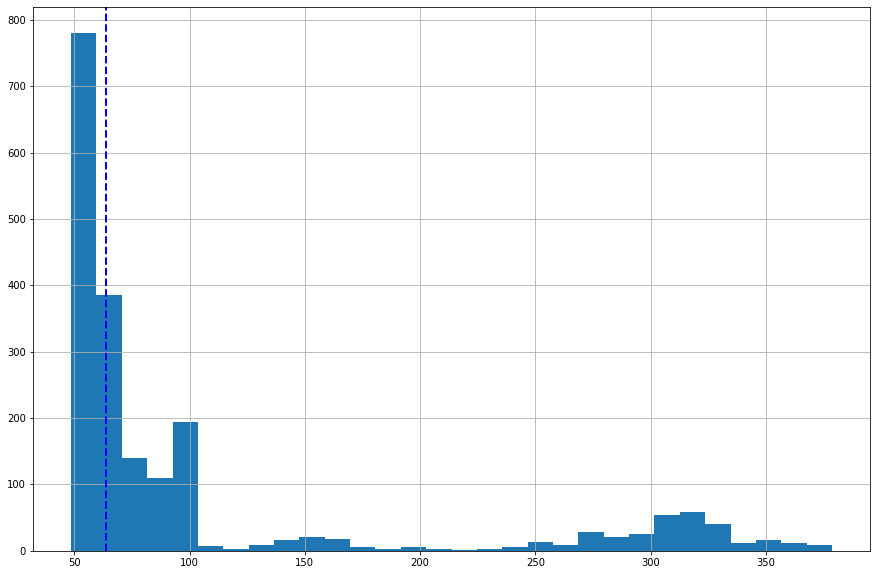

In [46]:
df['LTC'].hist(bins=30, figsize=(15,10)).axvline(df['LTC'].median(), color='b', linestyle='dashed', linewidth=2)

### Visualize absolute closing prices

The chart below shows absolute closing prices. 
It is not of much use as BTC closing prices are much higher 
then prices of ETH and LTC.

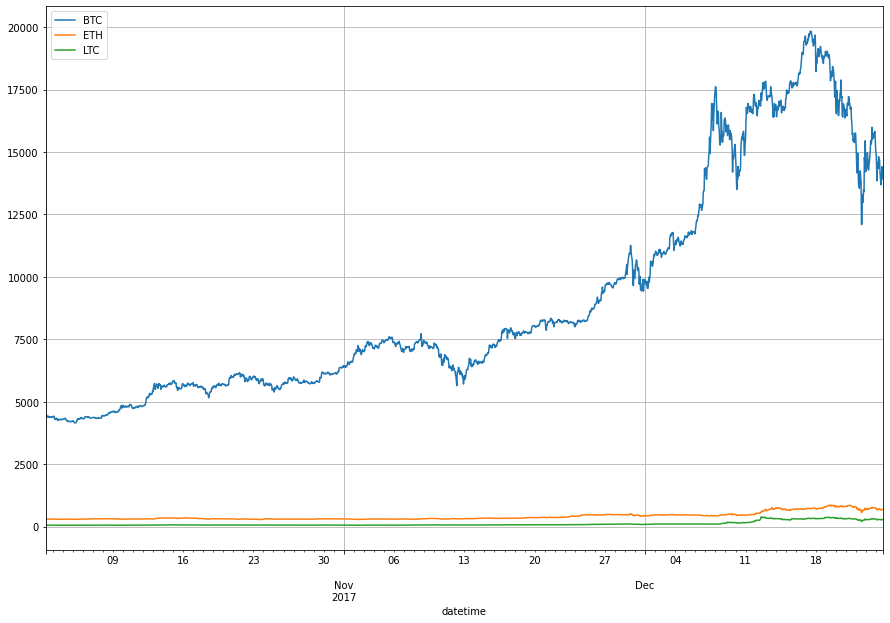

In [47]:
df.plot(grid=True, figsize=(15, 10))

### Visualize relative changes of closing prices

We are interested in a relative change of the price 
rather than in absolute price, so we use three different scales.

We see that closing prices move in tandem. When one coin closing price increases so do the other.

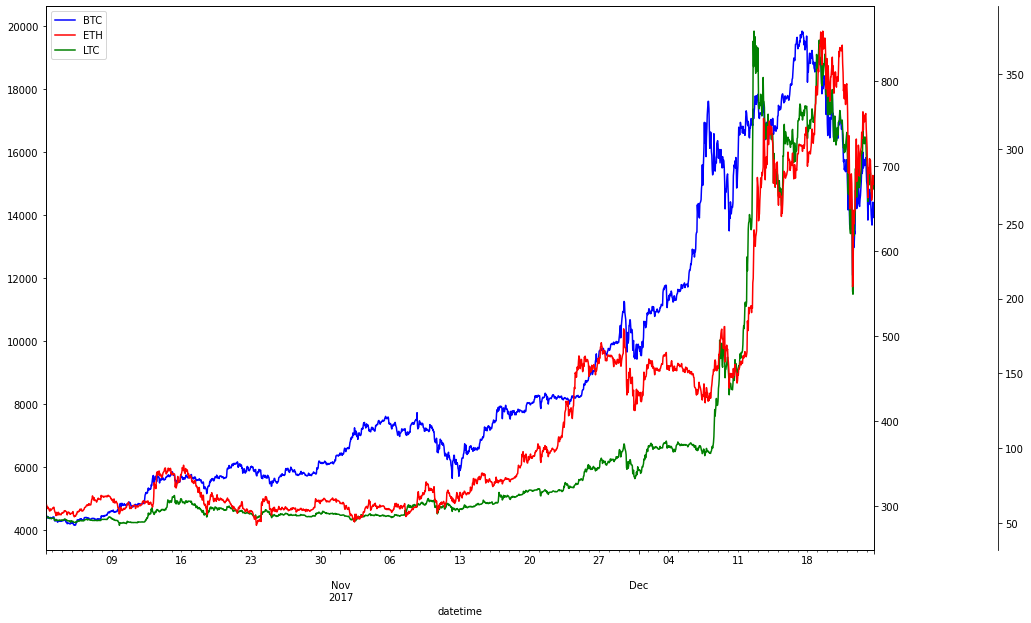

In [48]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
rspine = ax2.spines['right']
rspine.set_position(('axes', 1.15))
ax2.set_frame_on(True)
ax2.patch.set_visible(False)
fig.subplots_adjust(right=0.7)

df['BTC'].plot(ax=ax1, style='b-')
df['ETH'].plot(ax=ax1, style='r-', secondary_y=True)
df['LTC'].plot(ax=ax2, style='g-')

# legend
ax2.legend([ax1.get_lines()[0],
            ax1.right_ax.get_lines()[0],
            ax2.get_lines()[0]],
           ['BTC', 'ETH', 'LTC'])

### Measure correlation of closing prices 

We calculate [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)
between closing prices of BTC, ETH and LTC. 
Pearson correlation is a measure of the linear correlation between two variables X and Y. 
It has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

[Sifr Data](https://www.sifrdata.com/cryptocurrency-correlation-matrix/) daily updates Pearson correlations for many cryptocurrencies.

**Observations**
- Corelation matrix is symetric so we only show the lower half. 
- BTC, ETH and LTC were highly correlated in past 2 months. This means, when BTC closing price increased, ETH and LTC followed. 
- ETH and LTC were even more correlated with 0.9565 Pearson correlation coefficient.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


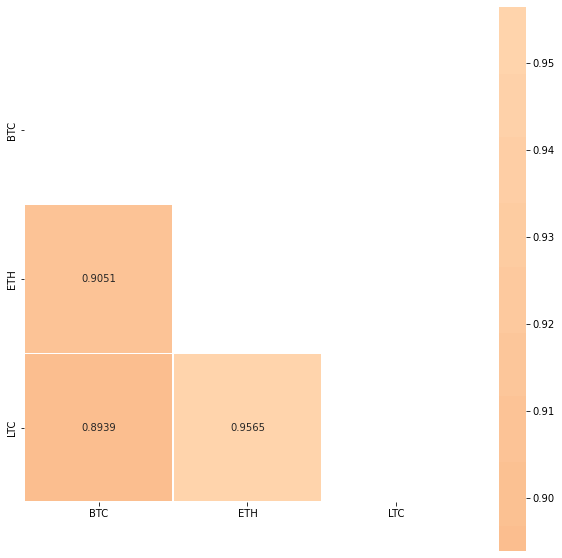

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

## Buy and hold strategy

[Buy and hold](https://www.investopedia.com/terms/b/buyandhold.asp) is a passive investment strategy in which an investor buys a cryptocurrency and holds it for a long period of time, regardless of fluctuations in the market. 

Let's analyze returns using buy and hold strategy for past 2.7 months. 
We calculate the return percentage, where $t$ represents a certain time period and $price_0$ is initial closing price:

$$
return_{t, 0} = \frac{price_t}{price_0}
$$

In [50]:
df_return = df.apply(lambda x: x / x[0])
df_return.head()

,BTC,ETH,LTC
datetime,,,
2017-10-02 08:00:00,1.000000,1.000000,1.000000
2017-10-02 09:00:00,1.003516,1.001560,1.001279
2017-10-02 10:00:00,1.002873,1.001925,0.998355
2017-10-02 11:00:00,0.988909,0.995520,0.987025
2017-10-02 12:00:00,0.985198,0.987192,0.981542


### Visualize returns

We show that LTC was the most profitable for time period between October 2, 2017 and December 24, 2017.

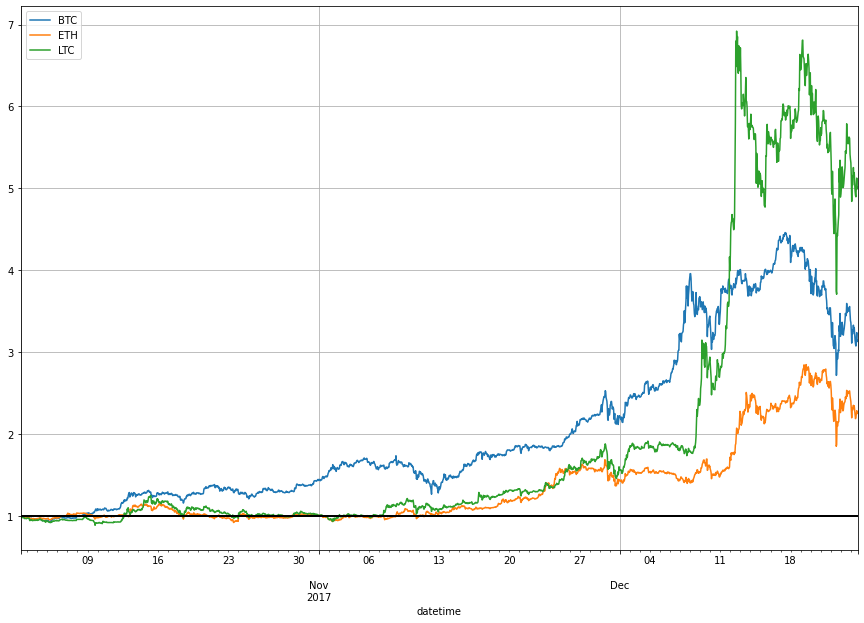

In [51]:
df_return.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)

## Conclusion

The cryptocurrencies we analyzed fluctuated a lot but all of gained in given 2.7 months period.

### What is the percentage increase?

,BTC,ETH,LTC
datetime,,,
2017-12-24 16:00:00,314.688065,226.900488,501.407164


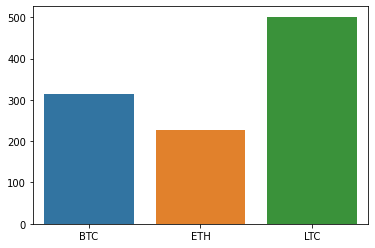

In [52]:
df_perc = df_return.tail(1) * 100
ax = sns.barplot(data=df_perc)
df_perc

### How many coins could we bought for $1000?

,BTC,ETH,LTC
datetime,,,
2017-10-02 08:00:00,0.224777,3.31818,18.274854


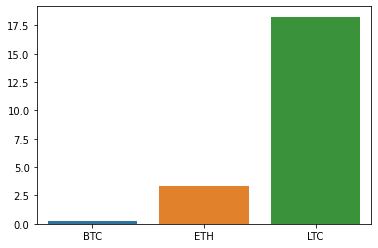

In [53]:
budget = 1000 # USD
df_coins = budget/df.head(1)

ax = sns.barplot(data=df_coins)
df_coins

### How much money would we make?

,BTC,ETH,LTC
datetime,,,
2017-12-24 16:00:00,3146.880655,2269.004878,5014.071637


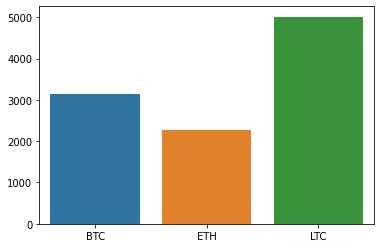

In [54]:
df_profit = df_return.tail(1) * budget

ax = sns.barplot(data=df_profit)
df_profit

# Cryptocurrency Analysis with Python - Log Returns

In [previous post]({{site.url}}/cryptocurrency/analysis/2017/12/25/cryptocurrency-analysis-with-python-part2.html), we analyzed raw price changes of cryptocurrencies. The problem with that approach is that prices of different cryptocurrencies are not normalized and we cannot use comparable metrics. 

In this post, we describe benefits of using log returns for analysis of price changes. You can download this [Jupyter Notebook]({{site.url}}/assets/notebooks/2017-12-29-cryptocurrency-analysis-with-python-part3.ipynb) and the [data]({{site.url}}/assets/data/). 

Follow me on [twitter](https://twitter.com/romanorac) to get latest updates.

![]({{site.url}}/assets/images/2017-12-29-cryptocurrency-analysis-with-python-part3/log_returns.png "Bitcoin, Ethereum, and Litecoin Log returns")

## Disclaimer
<span style="color:red">
**I am not a trader and this blog post is not a financial advice. This is purely introductory knowledge.
The conclusion here can be misleading as 
I analyze the time period with immense growth. **
</span>

## Requirements

- [SciPy - scientific and numerical tools for Python](https://www.scipy.org/)

For other requirements, see my
[first blog post]({{site.url}}/cryptocurrency/analysis/2017/12/17/cryptocurrency-analysis-with-python-part1.html)
of this series.

## Load the data

In [55]:
import pandas as pd

df_btc = pd.read_csv('BTC_USD_Coinbase_hour_2017-12-24.csv', index_col='datetime')
df_eth = pd.read_csv('ETH_USD_Coinbase_hour_2017-12-24.csv', index_col='datetime')
df_ltc = pd.read_csv('LTC_USD_Coinbase_hour_2017-12-24.csv', index_col='datetime')

In [56]:
df = pd.DataFrame({'BTC': df_btc.close,
                   'ETH': df_eth.close,
                   'LTC': df_ltc.close})
df.index = df.index.map(pd.to_datetime)
df = df.sort_index()

In [57]:
df.head()

,BTC,ETH,LTC
datetime,,,
2017-10-02 08:00:00,4448.85,301.37,54.72
2017-10-02 09:00:00,4464.49,301.84,54.79
2017-10-02 10:00:00,4461.63,301.95,54.63
2017-10-02 11:00:00,4399.51,300.02,54.01
2017-10-02 12:00:00,4383.00,297.51,53.71


In [58]:
df.describe()

,BTC,ETH,LTC
count,2001.000000,2001.000000,2001.000000
mean,9060.256122,407.263793,106.790100
std,4404.269591,149.480416,89.142241
min,4150.020000,277.810000,48.610000
25%,5751.020000,301.510000,55.580000
50%,7319.950000,330.800000,63.550000
75%,11305.000000,464.390000,100.050000
max,19847.110000,858.900000,378.660000


## Why Log Returns?

Benefit of using returns, versus prices, is normalization: measuring all variables in a comparable metric, thus enabling evaluation of analytic relationships amongst two or more variables despite originating from price series of unequal values (for details, see [Why Log Returns](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)).


Let's define return as:

$$
r_{i} = \frac{p_i - p_j}{p_j},
$$
where $r_i$ is return at time $i$, $p_i$ is the price at time $i$ and $j = i-1$.


### Calculate Log Returns

Author of [Why Log Returns](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)
outlines several benefits of using log returns instead of returns so we transform **returns** equation to **log returns** equation:

$$
r_{i} = \frac{p_i - p_j}{p_j}
$$

$$
r_i = \frac{p_i}{p_j} - \frac{p_j}{p_j}
$$

$$
1 + r_i = \frac{p_i}{p_j}
$$


$$
log(1+r_i) = log(\frac{p_i}{p_j})
$$

$$
log(1+r_i) = log(p_i) - log(p_j)
$$

Now, we apply the log returns equation to closing prices of cryptocurrencies:

In [59]:
import numpy as np

# shift moves dates back by 1
df_change = df.apply(lambda x: np.log(x) - np.log(x.shift(1))) 

In [60]:
df_change.head()

,BTC,ETH,LTC
datetime,,,
2017-10-02 08:00:00,NaN,NaN,NaN
2017-10-02 09:00:00,0.003509,0.001558,0.001278
2017-10-02 10:00:00,-0.000641,0.000364,-0.002925
2017-10-02 11:00:00,-0.014021,-0.006412,-0.011414
2017-10-02 12:00:00,-0.003760,-0.008401,-0.005570


### Visualize Log Returns

We plot normalized changes of closing prices for last 50 hours. Log differences can be interpreted as the percentage change.

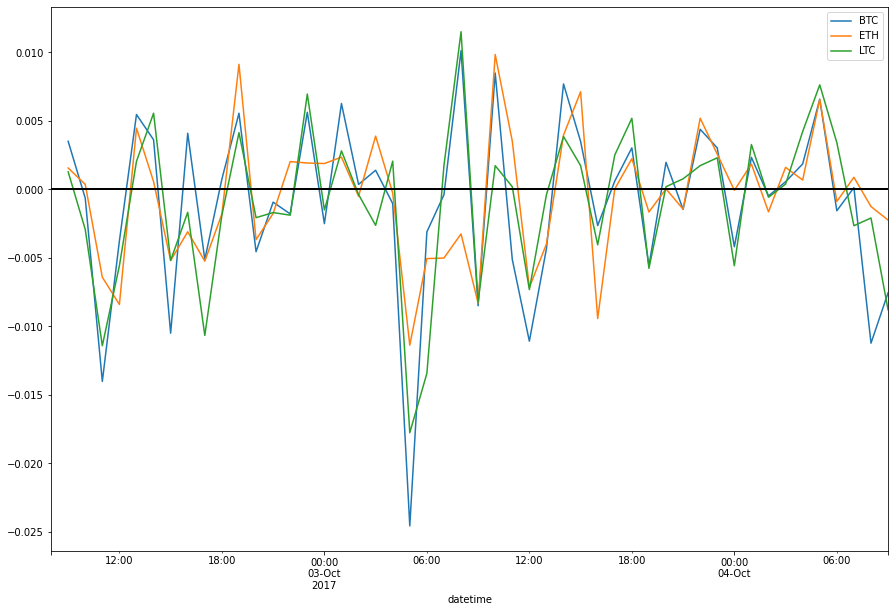

In [61]:
df_change[:50].plot(figsize=(15, 10)).axhline(color='black', linewidth=2)

### Are LTC prices distributed log-normally?

If we assume that prices are distributed log normally, 
then $log(1 + r_i)$ is conveniently normally distributed 
(for details, see [Why Log Returns](https://quantivity.wordpress.com/2011/02/21/why-log-returns/))

On the chart below, we plot the distribution of LTC hourly closing prices.
We also estimate parameters for log-normal distribution and plot estimated log-normal distribution with a red line.

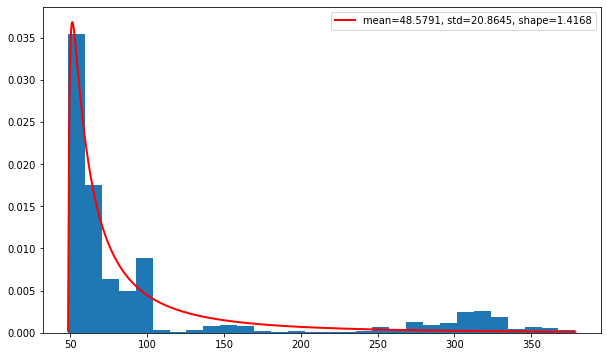

In [63]:

from scipy.stats import lognorm
import matplotlib.pyplot as plt
from scipy import stats

fig, ax = plt.subplots(figsize=(10, 6))

values = df['LTC']

shape, loc, scale = stats.lognorm.fit(values) 
x = np.linspace(values.min(), values.max(), len(values))
pdf = stats.lognorm.pdf(x, shape, loc=loc, scale=scale) 
label = 'mean=%.4f, std=%.4f, shape=%.4f' % (loc, scale, shape)

ax.hist(values, bins=30, density=True)
ax.plot(x, pdf, 'r-', lw=2, label=label)
ax.legend(loc='best')

### Are LTC log returns normally distributed?

On the chart below, we plot the distribution of LTC log returns.
We also estimate parameters for normal distribution and plot estimated normal distribution with a red line.

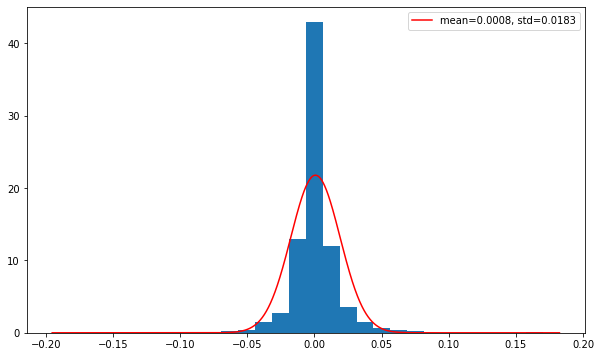

In [64]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

values = df_change['LTC'][1:]  # skip first NA value
x = np.linspace(values.min(), values.max(), len(values))

loc, scale = stats.norm.fit(values)
param_density = stats.norm.pdf(x, loc=loc, scale=scale)
label = 'mean=%.4f, std=%.4f' % (loc, scale)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(values, bins=30, density=True)
ax.plot(x, param_density, 'r-', label=label)
ax.legend(loc='best')

### Pearson Correlation with log returns

We calculate Pearson Correlation from log returns.
The correlation matrix below has similar values as the one at [Sifr Data](https://www.sifrdata.com/cryptocurrency-correlation-matrix/). 
There are differences because:
 - we don't calculate [volume-weighted average daily prices](https://www.investopedia.com/terms/v/vwap.asp)
 - different time period (hourly and daily),
 - different data source (Coinbase and Poloniex).
 
**Observations**
- BTC and ETH have moderate positive relationship,
- LTC and ETH have strong positive relationship.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


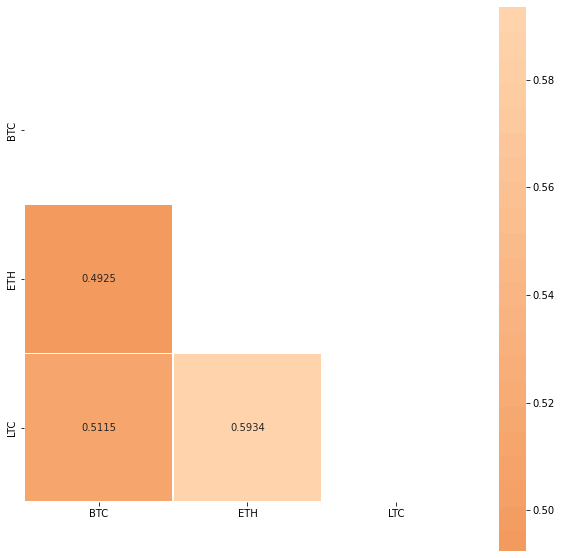

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = df_change.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, fmt = '.4f', mask=mask, center=0, square=True, linewidths=.5)

## Conclusion

We showed how to calculate log returns from raw prices with a practical example. 
This way we normalized prices, which simplifies further analysis. 
We also showed how to estimate parameters for normal and log-normal distributions.